In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor


In [ ]:
file_paths = [
    "D:\\ML Predictions\\AirPollutionUI\\air-pollution-ml\\flask-server\\AllPM_merged\\2021_merged_phora_newest.csv",
    "D:\\ML Predictions\\AirPollutionUI\\air-pollution-ml\\flask-server\\AllPM_merged\\2022_merged_phora_newest.csv",
    "D:\\ML Predictions\\AirPollutionUI\\air-pollution-ml\\flask-server\\AllPM_merged\\2023_merged_phora_newest.csv",
]

dataframes = [pd.read_csv(file) for file in file_paths]
combined_data = pd.concat(dataframes, ignore_index=True)
combined_data1 = combined_data.drop(columns=['Site','Parameter','Date (LT)','Conc. Unit', 'Duration', 'QC Name', 'time'])
combined_data_final = combined_data1.dropna()
combined_data_final

,Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Temperature (°C),dewpoint_2m,Relative Humidity (%),Precipitation (mm),windspeed_10m,Pressure (hPa)
0,2021,1,1,2,177.2,227,Very Unhealthy,156.0,6.2,-3.7,49.0,0.0,5.5,1017.9
1,2021,1,1,3,156.1,207,Very Unhealthy,135.0,11.4,-2.0,39.0,0.0,4.5,1019.1
2,2021,1,1,4,132.0,190,Unhealthy,108.0,15.5,-5.4,23.0,0.0,1.8,1019.7
3,2021,1,1,5,113.0,181,Unhealthy,94.0,17.2,-6.8,19.0,0.0,4.5,1018.9
4,2021,1,1,6,107.0,178,Unhealthy,101.0,18.5,-6.7,17.0,0.0,6.3,1018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24731,2023,12,30,1,64.5,156,Unhealthy,59.0,7.7,5.5,86.0,0.0,4.0,1019.2
24732,2023,12,30,2,72.2,160,Unhealthy,80.0,8.0,5.9,86.0,0.0,5.5,1019.7
24733,2023,12,30,3,91.6,170,Unhealthy,111.0,11.8,8.3,79.0,0.0,5.9,1020.1
24734,2023,12,30,4,65.3,156,Unhealthy,39.0,15.6,7.8,60.0,0.0,1.5,1020.4


In [14]:
numerical_dataset = combined_data_final[['Month','Day', 'Hour', 'Temperature (°C)', 'dewpoint_2m', 'Relative Humidity (%)', 'Precipitation (mm)', 'windspeed_10m', 'Pressure (hPa)', 'AQI']]

Q1 = numerical_dataset.quantile(0.25) #first 25% of the data
Q3 = numerical_dataset.quantile(0.75) #first 75% of the data
IQR = Q3 - Q1 #IQR = InterQuartile Range

scale = 1.4 #May need to play with this value to modify outlier detection sensitivity if need be
lower_lim = Q1 - scale*IQR
upper_lim = Q3 + scale*IQR

cols = numerical_dataset.columns[0:] # Look for oulierts in columns starting from CO(GT)

#Mask a masking condition that removes rows that have values above/below IQR limits
condition = ~((numerical_dataset[cols] < lower_lim) | (numerical_dataset[cols] > upper_lim)).any(axis=1)

#Generate new dataframe that has had its outliers removed
dataset_filtered = numerical_dataset[condition]
dataset_filtered

,Month,Day,Hour,Temperature (°C),dewpoint_2m,Relative Humidity (%),Precipitation (mm),windspeed_10m,Pressure (hPa),AQI
0,1,1,2,6.2,-3.7,49.0,0.0,5.5,1017.9,227
1,1,1,3,11.4,-2.0,39.0,0.0,4.5,1019.1,207
8,1,1,10,16.9,3.2,40.0,0.0,7.6,1015.6,221
9,1,1,11,15.3,4.5,49.0,0.0,4.0,1015.9,198
10,1,1,12,13.9,5.2,56.0,0.0,4.9,1016.3,191
...,...,...,...,...,...,...,...,...,...,...
24731,12,30,1,7.7,5.5,86.0,0.0,4.0,1019.2,156
24732,12,30,2,8.0,5.9,86.0,0.0,5.5,1019.7,160
24733,12,30,3,11.8,8.3,79.0,0.0,5.9,1020.1,170
24734,12,30,4,15.6,7.8,60.0,0.0,1.5,1020.4,156


In [15]:
from sklearn.preprocessing import StandardScaler

X = dataset_filtered.drop(columns=['AQI'])   #Replace 'AQI' with the name of your target column
y = dataset_filtered['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
import pickle

with open('Scaler_CatBoosting.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
#Training the CatBoost Regressor model

model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.025,
    depth=12,
    l2_leaf_reg=7,
    subsample=0.9,
    verbose=100,
    feature_border_type='Median',
    random_state=42
)

model.fit(X_train_scaled, y_train)

0:	learn: 47.1636100	total: 38.4ms	remaining: 57.6s
100:	learn: 23.4310351	total: 3s	remaining: 41.6s
200:	learn: 20.6351826	total: 6.13s	remaining: 39.6s
300:	learn: 19.0491956	total: 11s	remaining: 43.8s
400:	learn: 17.7834209	total: 19.3s	remaining: 52.9s
500:	learn: 16.6717266	total: 22.2s	remaining: 44.3s
600:	learn: 15.7390959	total: 25.1s	remaining: 37.6s
700:	learn: 15.0087419	total: 28s	remaining: 31.9s
800:	learn: 14.3628708	total: 30.9s	remaining: 27s
900:	learn: 13.7296428	total: 33.8s	remaining: 22.5s
1000:	learn: 13.1789656	total: 37.2s	remaining: 18.6s
1100:	learn: 12.6698313	total: 40.7s	remaining: 14.7s
1200:	learn: 12.1840809	total: 43.9s	remaining: 10.9s
1300:	learn: 11.7586773	total: 47s	remaining: 7.19s
1400:	learn: 11.3600314	total: 50s	remaining: 3.54s
1499:	learn: 10.9867323	total: 53.2s	remaining: 0us


In [ ]:
#Evaluating the model

from sklearn.metrics import root_mean_squared_error

y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Sqaure Error (MAE):", rmse)
print("R^2 Score:", r2)

print(y_pred)
print(len(y_pred))


Mean Absolute Error (MAE): 12.594976443423835
Root Mean Sqaure Error (MAE): 17.429962173938648
R^2 Score: 0.8659933432671129
[ 56.25924097 133.561846   165.16085734 ...  53.03254364  77.47548751
 149.9210717 ]
3900


In [ ]:
#Saving the model and scaler and pickle files

import pickle 

with open("AQI_Catboosting_phora_newest.pkl", "wb") as f:
    pickle.dump(model, f)

with open("Scaler_catboosting_phora_newest.pkl", "wb") as f:
    pickle.dump(scaler, f)

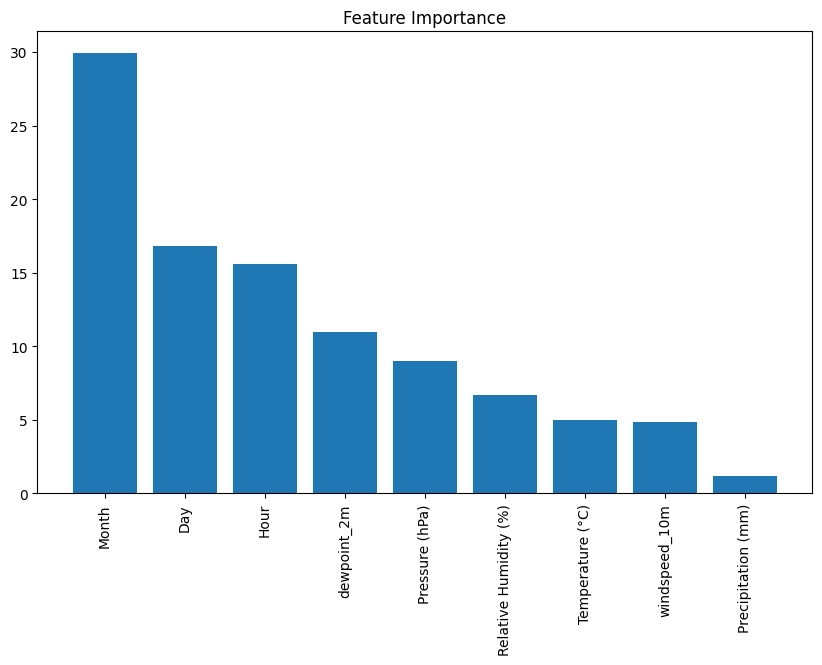

In [ ]:
#Feature Importance Plot

import matplotlib.pyplot as plt
import numpy as np
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.title('Feature Importance')
plt.show()


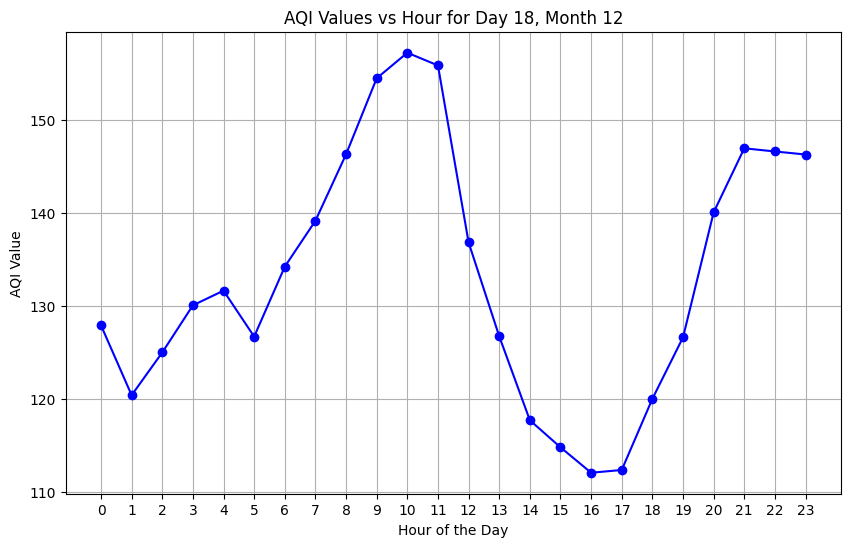

In [ ]:
#Plotting AQI vs Hour for a specific day and month

import matplotlib.pyplot as plt

selected_day = 18
selected_month = 12
one_day_df = final_df[(final_df['Day'] == selected_day) & (final_df['Month'] == selected_month)]

# Step 2: Plot AQI vs Hour
plt.figure(figsize=(10, 6))
plt.plot(one_day_df['Hour'], one_day_df['AQI'], marker='o', linestyle='-', color='b')

# Step 3: Customize the plot
plt.title(f"AQI Values vs Hour for Day {selected_day}, Month {selected_month}")
plt.xlabel("Hour of the Day")
plt.ylabel("AQI Value")
plt.xticks(one_day_df['Hour'])  # Ensure all hours are shown
plt.grid(True)
plt.show()
